# Inference

Load model, weights and do some inference!

In [45]:
# imports
import pandas as pd
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
import glob

# transformers
from torchvision import transforms
from skimage.transform import rescale, resize, downscale_local_mean

# dataset imports
import os
import torch
import torch.utils.data
import torchvision
import torch
import torch.nn as nn

# model imports
import copy

# evaluation imports
import time
from sklearn import metrics

In [56]:
# model 
model = torchvision.models.resnet18()
model.conv1 = nn.Conv2d(4, 64, (7, 7), 
                        stride=(2,2), 
                        padding=(3,3), 
                        bias=False)

# output features to 3 classification
model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=512,
        out_features=19
    ),
    torch.nn.Sigmoid()
)

In [57]:

# path for saving models
PATH = '../models/resnet18.pth'
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Dataset, Transformers and Dataloaders

In [58]:
class Tile(object):
    """
    Takes in:
    imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    Outputs:
    
    imgs = {
            'tiles': tiles
        }
        
    target = {
        'image_id': torch.tensor([idx]),
        'labels': np.array(df.iloc[idx, 3:])
    }
    """
    @staticmethod
    def tiled_img(r, g, b, y, box):
        """
        Find center of box. Crop the image using PIL
        at center, using desired tile size.
        """
        # (xmax-xmin) / 2 , (ymax - ymin) /2
        center = ( (box[2]-box[0])/2, (box[3]-box[1])/2 )
        left = box[0]
        top = box[1]
        right = box[2]
        bottom = box[3]
        
        # crop channels
        r = r.crop((left, top, right, bottom))
        g = g.crop((left, top, right, bottom))
        b = b.crop((left, top, right, bottom))
        y = y.crop((left, top, right, bottom))
        
        # return cropped channels using PIL 
        rgby = np.dstack((r,g,b,y))
    
        return(rgby)
    
    
    @staticmethod
    def split_mask(mask):
        # convert to array for individual segments
        mask = np.array(mask)
        # split into different segmentations
        obj_ids = np.unique(mask)
        # 0 is background, get rid
        obj_ids = obj_ids[1:]
        
        # split color-encoded mask into
        # a set of binary masks
        
        masks = mask == obj_ids[:, None, None] # HOW DOES THIS WORK
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        return boxes
        
        
    @staticmethod
    def gen_labels(labels, num_objs):
        """
        Take in numpy array of one hot encoded labels
        output:
        [N, OHE labels]
        where N is the number of objects or tiles
        """
        return [labels for i in range(num_objs)]
        
        
    def __call__(self, sample):
        imgs, target = sample
        
        # get masks
        boxes = self.split_mask(imgs['mask'])
         
        # list of tiled imgs
        tiles = list()
        for box in boxes:
            tiles.append(self.tiled_img(imgs['red'],
                                        imgs['green'],
                                        imgs['blue'],
                                        imgs['yellow'],
                                        box))
            
        # target
        new_target = {
        'image_id': target['image_id'],
        'labels': self.gen_labels(target['labels'], len(boxes))
        }
        
        
        return ((tiles, new_target))

In [59]:
class Rescale(object):
    """
    Rescale the tiles received.
    Return rescaled 4 channel images (numpy)
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # check output size is 
                                                     # right format
        self.output_size = output_size

    def __call__(self, sample):
        
        imgs, target = sample
        for i in range(len(imgs)):
            # numpy.shape responds with (H, W, C)
            h = imgs[i].shape[0] 
            w = imgs[i].shape[1] 

            if isinstance(self.output_size, int):
                if h > w:
                    new_h, new_w = self.output_size * h / w, self.output_size
                else:
                    new_h, new_w = self.output_size, self.output_size * w / h
            else:
                new_h, new_w = self.output_size

            new_h, new_w = int(new_h), int(new_w)

            #resize iamge
            imgs[i] = resize(imgs[i], 
                             (new_h, new_w))
        return ((imgs, target))

In [60]:
class ImageToTensor(object):
    """
    Custom to tensor class, does not accept dictionary.
    """

    @staticmethod
    def image_tensor(imgs):
        return [torch.from_numpy(im).permute(2,0,1) for im in imgs]
    
    
    @staticmethod
    def idx_tensor(idx):
        return torch.tensor(idx)
    
    
    @staticmethod
    def labels_tensor(labels):
        return[torch.from_numpy(l) for l in labels]
    
    
    def __call__(self, sample):
        imgs, target = sample
        # torch image: C X H X W
        t_tiles = self.image_tensor(imgs)
        idx = self.idx_tensor(target['image_id'])
        labels = self.labels_tensor(target['labels'])
        
        new_target = {
            'image_id': idx,
            'labels': labels
        }
        return ((t_tiles, new_target))

In [61]:
class HPAImageDataset(object):
    
    
    def __init__(self, root, transforms, df):
        self.root = root
        self.df = df
        self.transforms = transforms
 

    def __len__(self):
        return(len(self.df))
                          
    
    def __getitem__(self, idx):
        # load channels and masks for idx
        r_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_red.png')
        g_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_green.png')
        b_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_blue.png')
        y_path = os.path.join(self.root, "image", 
                              self.df.ID[idx]+'_yellow.png')
        
        mask_path = os.path.join(self.root, 
                                 "mask", 
                                 self.df.ID[idx]+'_predictedmask.png')

        # open imgs in PIL
        imgs = {
            'red': Image.open(r_path),
            'green': Image.open(g_path),
            'blue': Image.open(b_path),
            'yellow': Image.open(y_path),
            'mask': Image.open(mask_path)
        }
    
        #define target
        target = {
            'image_id': idx,
            'labels': self.df.iloc[0, 2:].to_numpy(dtype='float16')
        }
        
        if self.transforms is not None:
            # torchvision compose only accepts single input
            sample = self.transforms((imgs, target))
            imgs, target = sample
        # return((imgs, target))  if we want to include imge ID
        return((imgs, target['labels']))

In [89]:
# define transforms
def get_transform():
    custom_transforms = [Tile(), Rescale((224,224)), 
                         ImageToTensor()]
    return torchvision.transforms.Compose(custom_transforms)

In [90]:
# load test dataset
df = pd.read_csv('../input/inference_test/test.csv')

In [91]:
ROOT_DIR = '../input/inference_test/'

# create own Dataset
transformed_dataset = HPAImageDataset(root=ROOT_DIR,
                          transforms=get_transform(),
                          df=df,
                          )

In [92]:
def collate_fn(batch):
    anno = []
    tiles = []
    for b in batch:
        for label in b[1]:
            anno.append(label)
        for tile in b[0]:
            tiles.append(tile)
    return tuple(zip(tiles, anno))

In [93]:
test_loader = torch.utils.data.DataLoader(transformed_dataset,
                                          batch_size=1,
                                          shuffle=False, collate_fn=collate_fn)

In [106]:
test_batch = next(iter(test_loader))
test_batch2 = next(iter(test_loader))

This Image has label: tensor([1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], dtype=torch.float16)


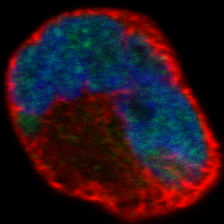

In [104]:
print('This Image has label: {}'.format(test_batch2[0][1]))
# sigle_batch[img ro label][img_n][tile_n]
(transforms.ToPILImage(mode='RGB')(test_batch2[0][0][:3, :, :]))

In [105]:
X = test_batch2[0][0].unsqueeze(0).float()
# [N, 19]
y = torch.reshape(test_batch2[0][1], (1,19))      

with torch.no_grad():
    pred = model(X)
print(pred)

tensor([[1.0000e+00, 3.2621e-10, 1.0000e+00, 5.1826e-11, 6.7051e-11, 2.1092e-11,
         1.5231e-10, 2.5208e-10, 1.1249e-10, 1.0000e+00, 1.7926e-11, 8.8150e-11,
         1.4464e-10, 1.6626e-10, 1.8356e-11, 1.8699e-10, 1.0000e+00, 3.3894e-12,
         9.6752e-11]])


Doesn't work...